# Smart Crop Selection: Using Machine Learning to Optimize Farming Decisions

![Farmer in a field](crop_selection_smart_farming.png)

Choosing the right crop to plant each season is a crucial decision for farmers aiming to maximize their yield and profitability. Soil health plays a significant role in crop growth, with factors such as nitrogen, phosphorus, potassium levels, and soil pH having a direct impact on productivity. However, assessing soil conditions can be expensive and time-consuming, leading farmers to prioritize certain metrics based on budget constraints.

The goal is to develop an accurate predictive model that can analyze soil composition and recommend the most suitable crop for optimal yield.

The dataset used for this project, `soil_measures.csv`, contains key soil metrics collected from various fields. Each row in the dataset represents a set of soil measurements and the corresponding crop that is best suited for those conditions. The features included in the dataset are:

- `"N"`: Nitrogen content ratio in the soil
- `"P"`: Phosphorous content ratio in the soil
- `"K"`: Potassium content ratio in the soil
- `"ph"` value of the soil
- `"crop"`: categorical values that contain various crops (target variable).

In [3]:
# All required libraries are imported here for you.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns 


In [4]:
# Load dataset
df = pd.read_csv('soil_measures.csv')

In [22]:
# Check for missing values
missing_values_count = df.isna().sum()
print(missing_values_count)

N       0
P       0
K       0
ph      0
crop    0
dtype: int64


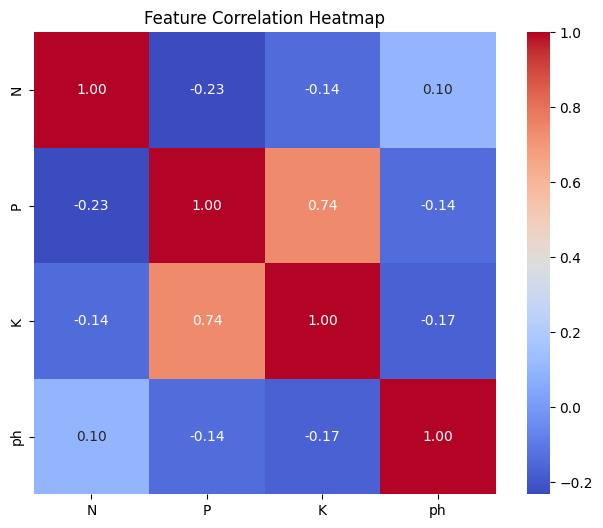

In [6]:
# Step 2: Analyze the correlation between features using a heatmap
numerical_features = ['N', 'P', 'K', 'ph']
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Feature Correlation Heatmap')
plt.show()

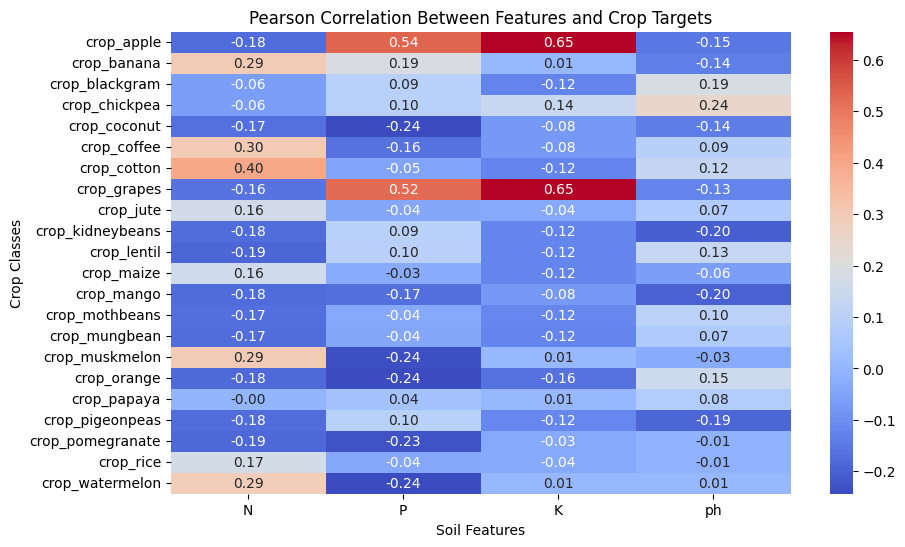

In [7]:
# Perform one-hot encoding on the categorical target variable 'crop'
df_encoded = pd.get_dummies(df, columns=['crop'])

# Calculate Pearson correlation matrix
correlation_matrix = df_encoded.corr(method='pearson')

# Extract correlations between features (N, P, K, ph) and target classes (one-hot encoded crops)
feature_columns = ['N', 'P', 'K', 'ph']
target_columns = [col for col in df_encoded.columns if col.startswith('crop_')]
correlation_with_target = correlation_matrix[feature_columns].loc[target_columns]

# Display the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_with_target, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Pearson Correlation Between Features and Crop Targets')
plt.xlabel('Soil Features')
plt.ylabel('Crop Classes')
plt.show()

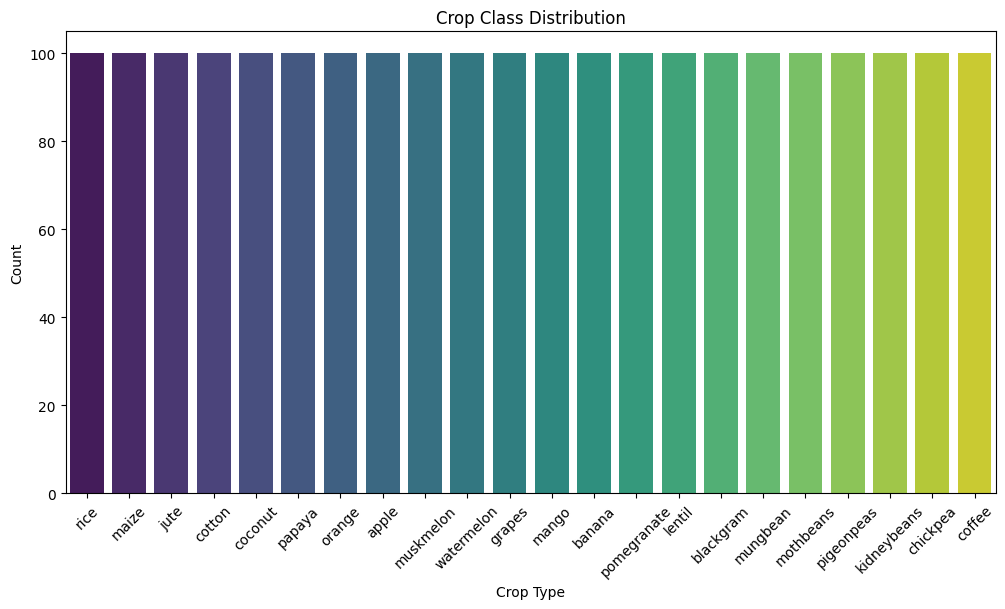

In [11]:
# Count occurrences of each crop category
target_counts = df['crop'].value_counts()

# Plot the class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=target_counts.index, y=target_counts.values, hue=target_counts.index, palette='viridis', dodge=False, legend=False)
plt.xticks(rotation=45)
plt.title('Crop Class Distribution')
plt.xlabel('Crop Type')
plt.ylabel('Count')
plt.show()


In [13]:
# Feature and target selection
X = df[['N', 'P', 'K', 'ph']]
y = df['crop']

In [14]:
# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Preprocessing: Standardize numerical features
numerical_features = ['N', 'P', 'K', 'ph']
X[numerical_features] = X[numerical_features].astype('float64')
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numerical_features] = scaler.fit_transform(X[numerical_features])

# print(X_scaled.dtypes)
# print(X_scaled.head())

C:\Users\tungv\AppData\Local\Temp\ipykernel_9712\3767542129.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_features] = X[numerical_features].astype('float64')


In [17]:
# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

In [18]:
# Define parameter grids for XGBoost and LightGBM
xgb_params = {
    'max_depth': [10, 20],
    'learning_rate': [0.001, 0.1, 1],
    'n_estimators': [100, 200, 500],
    'subsample': [0.7, 0.9]
}

knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [19]:
# Perform hyperparameter tuning using cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# XGBoost tuning
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss',verbosity=1)
xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=xgb_params, cv=kf, scoring='accuracy', n_jobs=1, verbose=1)
xgb_grid.fit(X_train, y_train)

# Hyperparameter tuning for KNN
knn_model = KNeighborsClassifier()
knn_grid_search = GridSearchCV(estimator=knn_model, param_grid=knn_param_grid, cv=kf, scoring='accuracy', n_jobs=1, verbose=1)
knn_grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

XGBoost Macro F1-Score: 0.7915767386867103
XGBoost Accuracy: 0.7977
Best parameters for XGBoost: {'learning_rate': 0.001, 'max_depth': 20, 'n_estimators': 500, 'subsample': 0.7}
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        20
           1       1.00      1.00      1.00        20
           2       0.61      0.85      0.71        20
           3       1.00      1.00      1.00        20
           4       0.70      0.95      0.81        20
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        20
           7       0.62      0.50      0.56        20
           8       0.65      0.85      0.74        20
           9       0.83      1.00      0.91        20
          10       0.62      0.40      0.48        20
          11       0.95      1.00      0.98        20
          12       0.93      0.70      0.80        20
          13       0.94      0.80      0.8

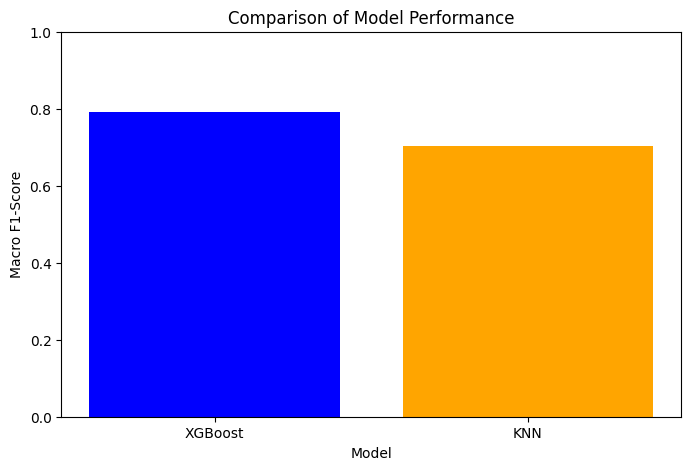

In [20]:
# Evaluate models
xgb_best_model = xgb_grid.best_estimator_
xgb_pred = xgb_best_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred, average='macro')

print("XGBoost Macro F1-Score:", xgb_f1)
print(f'XGBoost Accuracy: {xgb_accuracy:.4f}')
print(f"Best parameters for XGBoost: {xgb_grid.best_params_}")
print(f"Classification Report:\n{classification_report(y_test, xgb_pred)}")

best_knn_model = knn_grid_search.best_estimator_
knn_pred = best_knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred, average='macro')

print("KNN Macro F1-Score:", knn_f1)
print("Best parameters for KNN:", knn_grid_search.best_params_)
print("KNN Accuracy:", knn_accuracy)
print(classification_report(y_test, knn_pred))

# Plot comparison of macro F1-scores
models = ['XGBoost', 'KNN']
f1_scores = [xgb_f1, knn_f1]

plt.figure(figsize=(8, 5))
plt.bar(models, f1_scores, color=['blue', 'orange'])
plt.xlabel('Model')
plt.ylabel('Macro F1-Score')
plt.title('Comparison of Model Performance')
plt.ylim(0, 1)
plt.show()

<Figure size 1000x600 with 0 Axes>

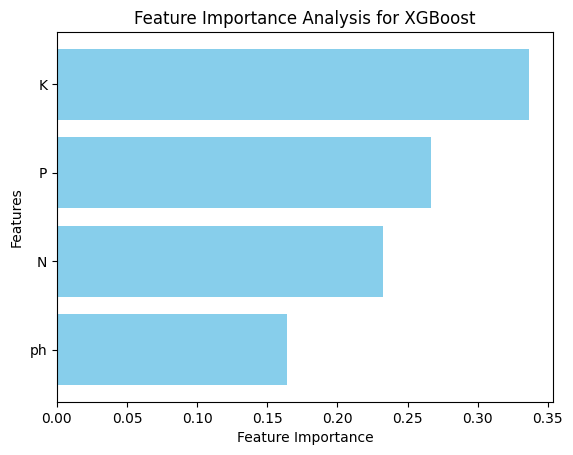

In [21]:

# Get feature importance from the XGBoost model
feature_importance = xgb_best_model.feature_importances_
feature_names = X_train.columns

# Create a sorted index for the features by importance
sorted_idx = np.argsort(feature_importance)[::-1]

# Sort feature names and importance values for plotting
sorted_feature_names = feature_names[sorted_idx]
sorted_feature_importance = feature_importance[sorted_idx]

# Plot the feature importance as a bar chart
plt.figure(figsize=(10, 6))
plt.figure()
plt.barh(sorted_feature_names, sorted_feature_importance, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Analysis for XGBoost')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features on top
plt.show()